# Cogs 118a Final Project: What kind of Beer should you try?

# Group Members

- George Liu, A15836054
- Xinyao Yi, A59019592
- Yingnan Yang, A16018172

### TODO List:
- baseline model of someone else's work (add a reference)
- more visualizations?
- add one more point in discussion of results
- conclusion


# Abstract
For adults, beer is one of the most highly consumed beverages; wouldn't you want to find a beer that is best for you? In order to do this, we want to examine how people rate beers. This includes things such as alcohol percentage, smell, and taste. Our goal is to build a model that predicts the ratings of beer given these attributes/features, extend the model to also recommend beers based upon your own preferences to these features.

Once we filter our dataset with the necessary features, we will train a baseline linear regression model and then a more complex fully connected neural network to see how it performs, using metrics such as RMSE, MAE, and R2 correlation coefficient. These metrics will help us determine the best model, and in turn allow us to recommend the best beer for you.

# Background
Our research problem is pretty unique in that researches don’t look into a topic like this. Mostly, this is because this topic is not super important to globalization and technological improvements. There are some works that are similar in topic, but none are academic. 

One way people use this dataset is to research the types of preferences people have in beer, things like how much foam a person wants, how much alcohol percentage is in the drink, etc. This mostly is used for improving the sales of beer and crafting the best drink. <sup>[1](#preferences)</sup>

Others have used beer reviews as a way for classification, being easily able to classify a beer into some categories for ease and also increases sales. <sup>[2](#classification)</sup>

A similar drink to beer is wine, and they are experimenting with computer vision to find when the optimal time is to use the ingredients, aka harvesting the grapes. A similar application can be used on barley, the ingredient to make beer. <sup>[3](#beer)</sup>

# Problem Statement/Research Problem
We aim to suggest the best beer for you based upon common beer preferences; things such as alcohol level, appearence, bitterness, etc. In the process of doing this, we will also aim to predict ratings on a scale 1-5, based upon these preferences; which can be replicated through our model architecture (there is no randomness). This problem is both quantifiable (as our predicted ratings we can get a definite number), and also measurable, through our error metrics that we present below.

# Dataset

https://www.kaggle.com/datasets/rdoume/beerreviews
This dataset can be found above at the link provided. It around 1.5 million beer reviews, and 13 total features. Each sample will consist of something similar to the name of the drink, a few columns representing the preferences of beers like alcohol level, and then the overall review rating. For our data, we need preprocess by filtering out useless columns and also selecting columns that can easily fit into our neural network architecture (for example getting columns that are integers/floats). Additionally, we will also have to one hot encode features that are important but categorical variables, for instance beer style. We also should drop any sample that is empty in the columns that we find useful.

To create our training set and test set, we need to first extract the overall rating score from the dataset as our y values (labels). Then, we extract all the columns that we find important and use that as our X. Then we can use test_train split to get the necessary proportions for our model to be generalizable. We can also split into a validation set, because we have so much data. Something to note is that our labels (y) are on a scale from 1-5, with increments of 0.5. This will affect our model selection later.

Below, you will be able to see all the steps we took to accomplish what we explained above to preprocess our dataset.

In [1]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

2023-03-22 21:20:35.198553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('beer_reviews.csv')

In [3]:
df = df.dropna()

In [4]:
df.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


##### Some EDA to understand our data better

Creating a beer dictionary to pull up the names later.


In [5]:
beer_dict = dict(zip(df['beer_beerid'],df['beer_name']))

Getting the true review score

In [6]:
y = df.loc[:, 'review_overall']

We can see that all the labels are on a scale of 1-5, incrementing by 0.5.

In [7]:
np.unique(y)

array([0. , 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

##### Checking for Bias

Here, we check if there are any biases in the beer style in the market.

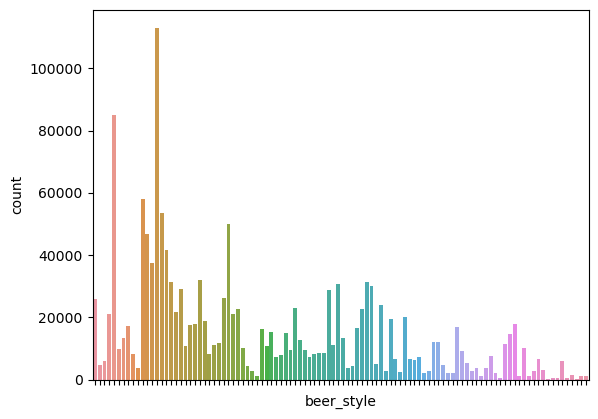

In [8]:
ax = sns.countplot(x=df['beer_style'], data=df)
ax.set(xticklabels=[])
plt.show()

We can see there are many beer styles in our dataset, but a few of them are outliers; they are reviewed way more than other beers.

Here, we check if there are any biases in our review.

<AxesSubplot:xlabel='review_overall', ylabel='count'>

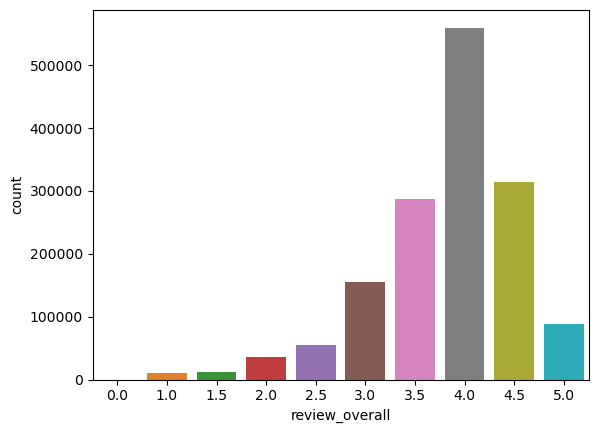

In [9]:
sns.countplot(x=df['review_overall'],data=df)

We can see our data is really skewed, most of the reviews are 4.0,4.5.

In [10]:
df = df.drop(['brewery_id','brewery_name','review_time','review_profilename', 'beer_name','review_overall'],axis=1)

Let's see if there are any correlation between our features, this may impact our model selection.

<AxesSubplot:>

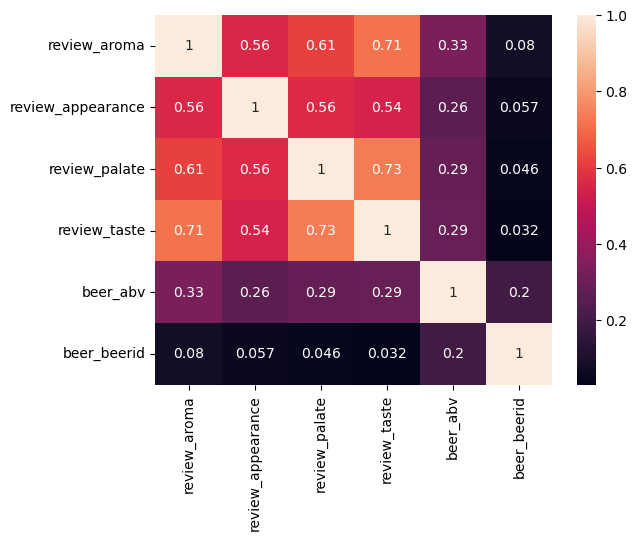

In [11]:
sns.heatmap(df.corr(), annot=True)

As we can see from our features, there are a few features that seem to be correlated; mostly all the reviews. This makes sense to us, since we know that these reviews are mostly what is making up the actual rating. However, because of this, we need to account for possible multicollinearity in model selection.

We want beer style to affect the rating, so we need to one hot encode it since it is a categorical variable

In [12]:
one_hot = pd.get_dummies(df['beer_style'])
df = pd.concat([df, one_hot], axis=1)
X = df.drop('beer_style', axis=1)

Looking at keys for one hot:

In [13]:
one_hot = one_hot.columns.tolist()
one_hot[:5]

['Altbier',
 'American Adjunct Lager',
 'American Amber / Red Ale',
 'American Amber / Red Lager',
 'American Barleywine']

##### Below are our independent variables and their brief descriptions:
Looking at keys for X (i.e., the independent variables). Our <b>independent variables are</b>: review of aroma, review of appearance, review of palate, review of taste, alcohol content, and beer style (one-hot coded: Altbier, American Adjunct Lager, ..., Winter Warmer, Witbier). Here are the brief descriptions for these IVs:

In [14]:
X.head()

,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,Altbier,American Adjunct Lager,American Amber / Red Ale,American Amber / Red Lager,...,Scotch Ale / Wee Heavy,Scottish Ale,Scottish Gruit / Ancient Herbed Ale,Smoked Beer,Tripel,Vienna Lager,Weizenbock,Wheatwine,Winter Warmer,Witbier
0,2.0,2.5,1.5,1.5,5.0,47986,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.5,3.0,3.0,3.0,6.2,48213,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.5,3.0,3.0,3.0,6.5,48215,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,3.5,2.5,3.0,5.0,47969,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.5,4.0,4.0,4.5,7.7,64883,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
X.keys()

Index(['review_aroma', 'review_appearance', 'review_palate', 'review_taste',
       'beer_abv', 'beer_beerid', 'Altbier', 'American Adjunct Lager',
       'American Amber / Red Ale', 'American Amber / Red Lager',
       ...
       'Scotch Ale / Wee Heavy', 'Scottish Ale',
       'Scottish Gruit / Ancient Herbed Ale', 'Smoked Beer', 'Tripel',
       'Vienna Lager', 'Weizenbock', 'Wheatwine', 'Winter Warmer', 'Witbier'],
      dtype='object', length=110)

In [16]:
X.dtypes

review_aroma         float64
review_appearance    float64
review_palate        float64
review_taste         float64
beer_abv             float64
                      ...   
Vienna Lager           uint8
Weizenbock             uint8
Wheatwine              uint8
Winter Warmer          uint8
Witbier                uint8
Length: 110, dtype: object

In [17]:
X.describe()

,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid,Altbier,American Adjunct Lager,American Amber / Red Ale,American Amber / Red Lager,...,Scotch Ale / Wee Heavy,Scottish Ale,Scottish Gruit / Ancient Herbed Ale,Smoked Beer,Tripel,Vienna Lager,Weizenbock,Wheatwine,Winter Warmer,Witbier
count,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,...,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06,1.518478e+06
mean,3.746218e+00,3.850383e+00,3.753735e+00,3.804082e+00,7.042488e+00,2.140575e+04,4.754102e-03,1.907436e-02,2.748212e-02,5.668834e-03,...,1.097810e-02,5.616808e-03,1.797194e-03,1.863708e-03,1.973753e-02,5.488390e-03,6.092285e-03,2.369478e-03,1.316384e-02,1.887021e-02
std,6.953440e-01,6.143106e-01,6.793350e-01,7.286079e-01,2.322568e+00,2.178033e+04,6.878593e-02,1.367865e-01,1.634836e-01,7.507797e-02,...,1.041997e-01,7.473462e-02,4.235523e-02,4.313045e-02,1.390970e-01,7.388012e-02,7.781499e-02,4.861959e-02,1.139761e-01,1.360667e-01
min,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00,1.654000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00,1.283000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00,3.923600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01,7.731600e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


##### Checking our reviews data for outliers:

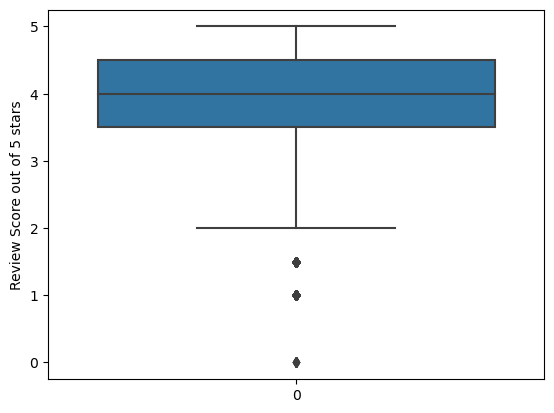

<Figure size 1200x1200 with 0 Axes>

In [18]:
sns.boxplot(data=y);
plt.ylabel('Review Score out of 5 stars')
plt.figure(figsize=(12,12));
plt.show()

We can see most of our beer reviews are around 4 stars, which makes sense logically. Most people when rating will just give above average if it is not exceptional or terrible. However, if a beer is terrible, then we can see some outliers in the graph. However, it seems like we don't have too many outliers, so perhaps if we decided to use regularization, we could use L2 regularization instead of L1.

##### Some Basic Model Selection

In our solution to the research problem, our dataset is huge. We have over 1.5 million samples, which means we can split our data into train, test, and validation. We don't need things like nested cross validation or k-folds, since those are techniques used when data is sparse.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [20]:
# convert everything to float for ease of use
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)

# Proposed Solution:
We will first create a baseline decision tree model to get a feel for how it performs. We don't expect this to be great, because it will train slow compared to a neural network and is prone to overfitting since we haven't done any particular model selection on it. However, it will help determine the relationship between features and help select which features are the most important to help other models.  We will improve the tree model using a grid search to get the most optimal parameters.

From these results, we will create a fully connected neural network, which is useful because it can use backpropogation to fix previous misclassifications. This will make the model much more accurate. 

Finally, using the neural network, we will create a basic recommendation system that takes input from the user and inputs into our model to predict. We will need to add some logic to return the name of the beer that the model prediction corresponds to.

# Evaluation Metrics:

Our model isn't doing any classification, we already know all drinks that we predict are going to be beers. That means things like confusion matricies, F1 score, precision, etc. are not applicable. Instead, we would have to use things like Mean Absolute Error, Root Mean Squared Error, and R2 correlation coefficients to evaluate our models. 

We will mostly evalute on mean absolute error, because of our prediction rating system. When we make a mistake, we only care how far it is from the true predicted value, not the direction it is in. Therefore, to compute this distance MAE is the best choice.

# Outside Baseline Model :


For baseline, we followed the predictAsAverage function in Kaggle(https://www.kaggle.com/code/generaltuboshu/kernel2b95905331/notebook). 
This baseline first find the globle average rating(3.8181978730995043) of the training set. Then they use the average rating as prediction for the test set. The mean square error of this baseline is 0.513.

Additionaly, they also tested 2 baselines from the "BaselineOnly" function in the suprise package. From the documentation, "BaselineOnly" function predict the baseline estimate given user and item. This function offers two ways the estimate can be computed: Stochastic Gradient Descent (SGD) and Alternating Least Squares (ALS). They found the MSE for SGD to be 0.3897 (baselineOnlySGD() function). The MSE for ALS is 0.3663 (baselineOnlyALS() function).








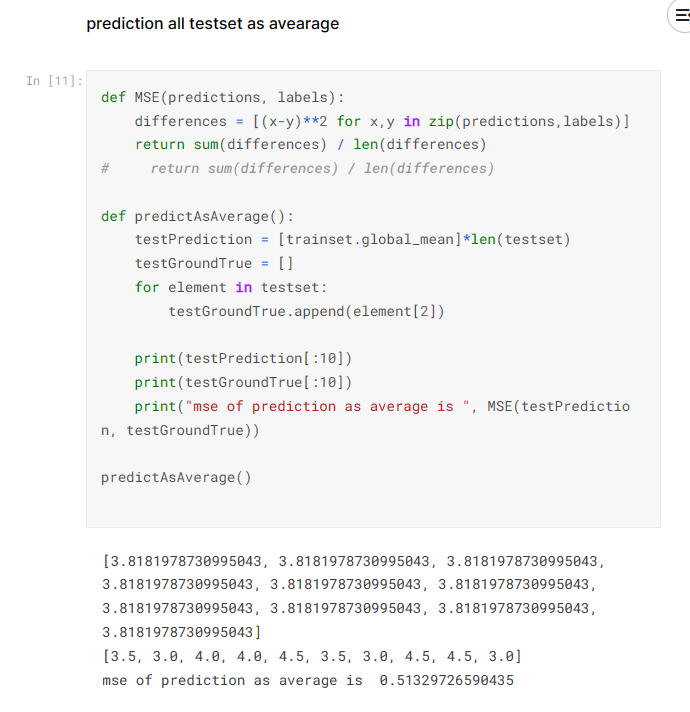

The above screenshot is their code predicting the average rating for all test sets.

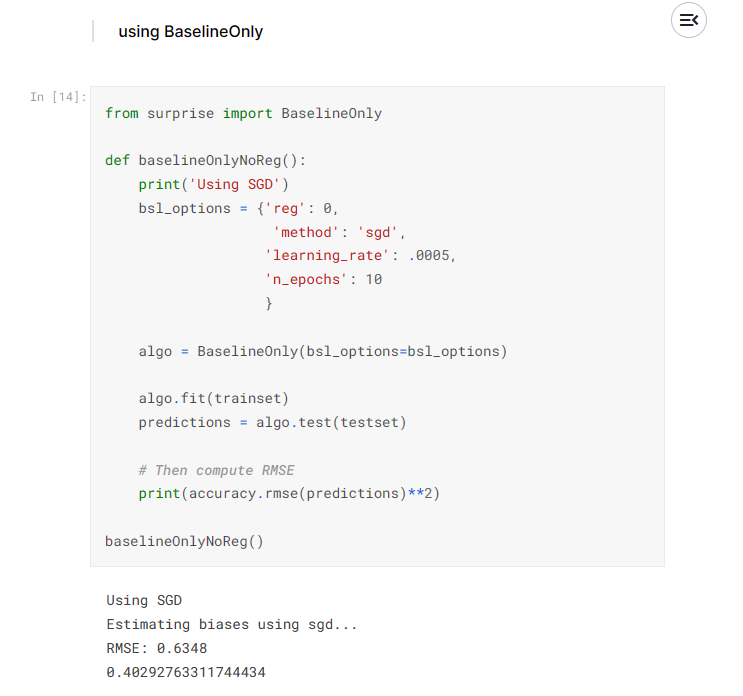

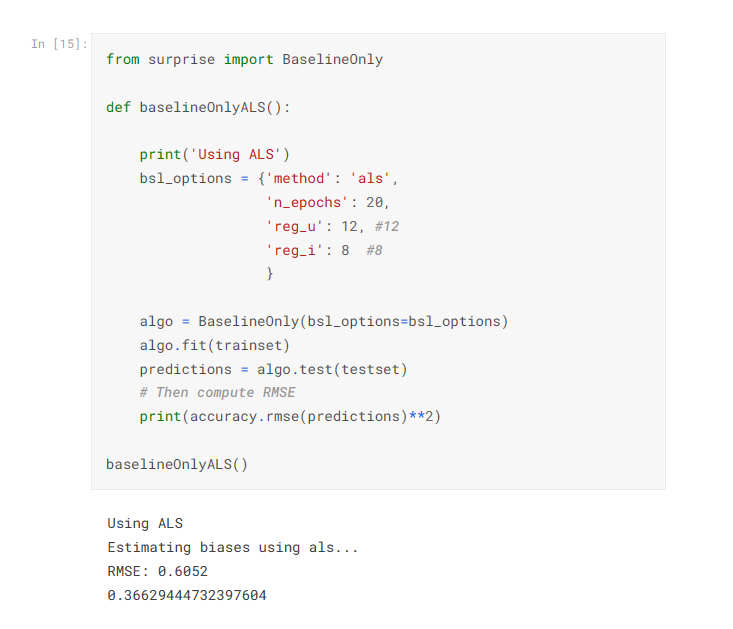

The above screenshot is their code of "BaselineOnly" function predict the baseline estimate by Alternating Least Squares (ALS). 

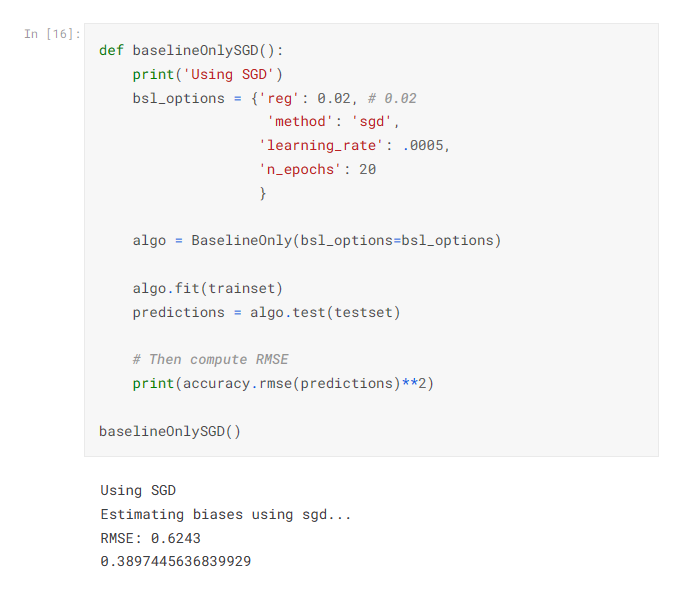

The above screenshot is their code of "BaselineOnly" function predict the baseline estimate by Stochastic Gradient Descent (SGD).

# Results:


### Subsection 1: Our own decision tree baseline model

##### A little behind Model Selection
Reasoning behind selecting tree as our baseline model: At this point, we still don't know too much about our data; only that there are outliers and also that our ratings are heavily biased. We also know that our features have both categorical as well as numerical data, and that there is possible multicollinearity between features.

Choosing Decision trees is a good idea because it can handle all these conditions: most notably, the bias in our data, while also not assuming anything about our data (unlike OLS implementation) and trains very quickly to get good enough results to interpret. One of these intepretations that trees specifically provide that we can use later in other models is feature importance, so we can put weight on that feature in the future. Decision trees also can handle multicollinearity, so we wouldn't have to worry about that.


Other simplistic models that we learned in class that could be good regression baseline models are linear regression and SVM, however, in this case, we are unsure of our data is actually linear. Fitting a linear line on nonlinear data would make the model perform poorly, and both of these models are sensitive to the rating bias we have in our data. Additionally, linear regression fails when there is multicollinearity.

In [21]:
model = DecisionTreeRegressor(max_depth=3)

In [22]:
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3)

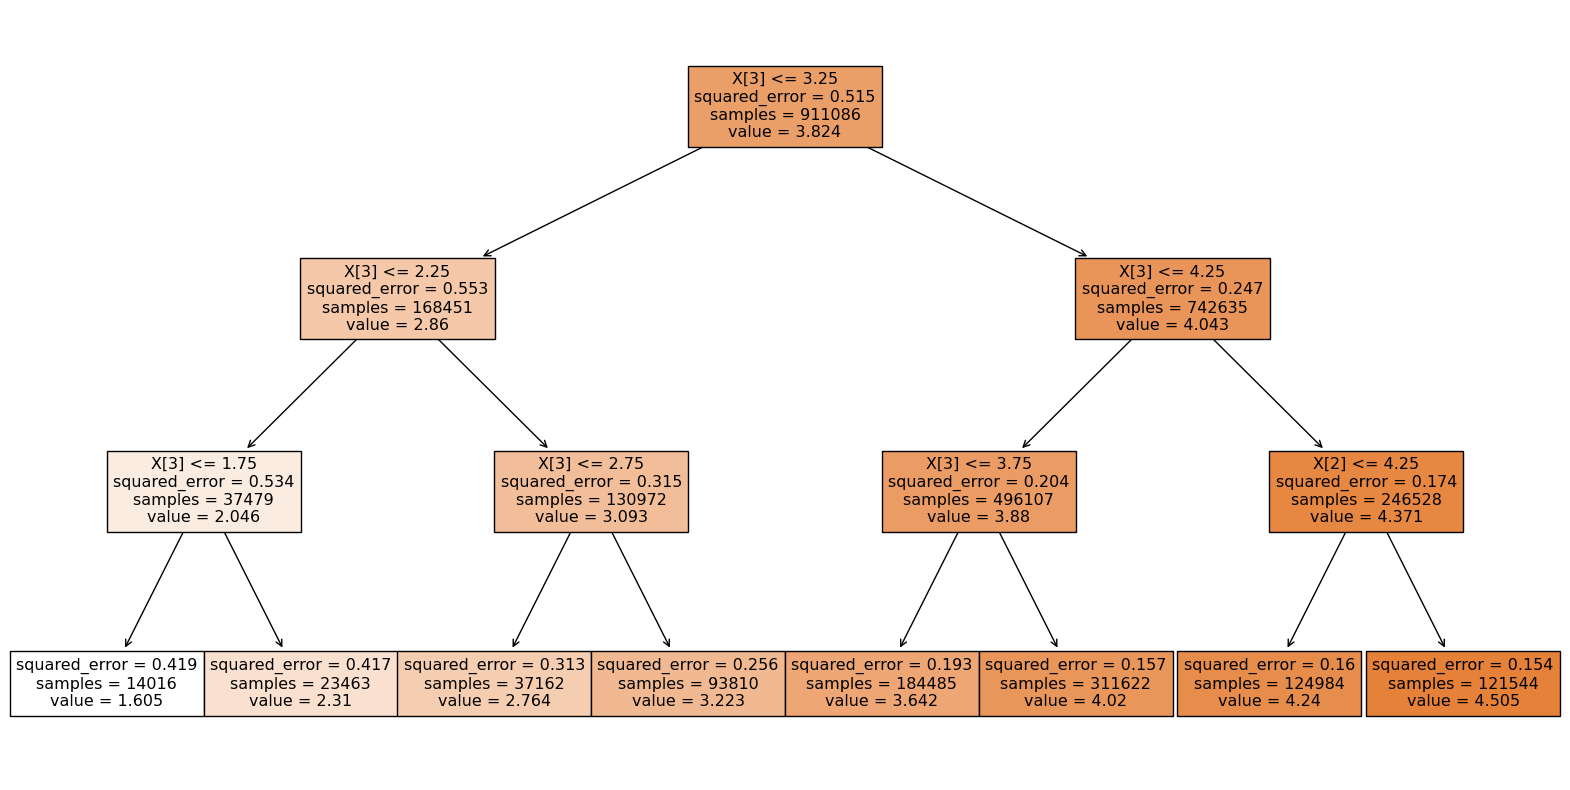

In [23]:
plt.figure(figsize=(20,10))
plot_tree(model, filled=True)
plt.show()

In the figure above, we can see a visualization of how our tree is structured/how the model makes its decisions. Since we specificed a max depth of 3, our model is only 3 layers.

Note: In our improved tree, this visualization can also be seen using the same code, however it is unreadable since there are so many layers and parameters so we omitted it.

In [24]:
feature_importances = model.feature_importances_
feature_importances = sorted(zip(X.columns, feature_importances))
max(feature_importances)

('review_taste', 0.985284179045517)

We can see in our model, the most important feature is the taste. However, it is taking way too much percentage, the other columns should have some weight. This is something to consider when we implement our further models.

In [25]:
y_pred = model.predict(X_val)

In [26]:
####### See here! if here is X_val, then below should be y_val?
####### x_val, y_val.

In [27]:
y_pred[:5]

array([4.2398467 , 3.6422907 , 3.6422907 , 4.02011732, 4.02011732])

In [28]:
y_test[:5]

array([4. , 4.5, 5. , 4. , 4.5], dtype=float32)

In [29]:
mae = mean_absolute_error(y_val, y_pred)
mae

0.321302087303361

In [30]:
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.4377291495473541

In [31]:
r2 = r2_score(y_val, y_pred)
r2

0.6262170239566527

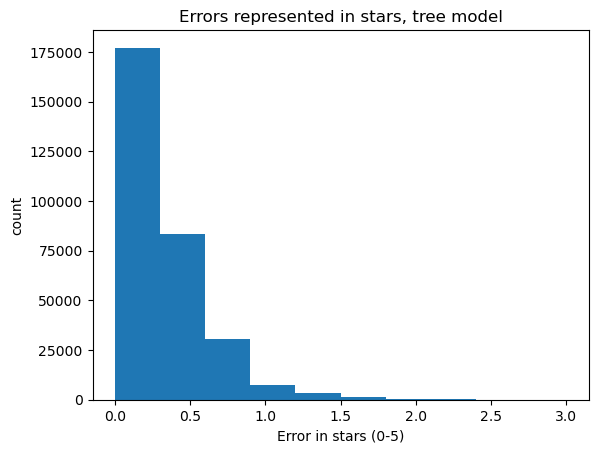

In [32]:
abs_error = np.abs(np.array(y_val) - np.array(y_pred).flatten())
plt.hist(abs_error, bins=10, range=(0,3))
plt.ylabel('count')
plt.xlabel('Error in stars (0-5)')
plt.title('Errors represented in stars, tree model')
plt.show()

As we can see, our own baseline decision tree is ok, but probably can be improved with some parameter tuning. As described before, the main error metric to look at is MAE, since we don't care what direction our error is off by, we only care about the true distance that the predicted rating is from the true rating.

In the next section, we used a randomized grid search to improve the model's performance.

### Subsection 2 Improved Decision Tree

###### A little behind our model selection:

#### Randomized Grid Search

Our dataset is massive. We initally used a regular grid search to find the best parameters, but exhausting each possible parameter to test its performance proved to take way too long. Instead, we choose to use a randomized grid search, which was mentioned in class. Basically by choosing this model, we sacrifice possible improvements in performance for speed in search, which is something we are willing to do. Therefore, to further improve this model, we could use the regular grid search in the future.

In [33]:
param_dist = {"max_depth": [3, 5, 7, 10],
               "min_samples_split": randint(2, 20),
               "min_samples_leaf": randint(1, 20)}

Here, since we already have ran this code before, we don't want to run it again since it takes a long time. So, we just hard coded the values that the random search found.

In [34]:
mode = "none"

In [35]:
if mode == "search":
    model = DecisionTreeRegressor()
    random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42, n_jobs=-1)
    new_model = random_search.fit(X_train, y_train)
    print('Best Score: %s' % new_model.best_score_)
    print('Best Hyperparameters: %s' % new_model.best_params_)

In [36]:
best_score = 0.677181106120889
best_depth = 10
best_min_samples_leaf = 12
best_min_samples_split = 7

Fitting our tree on our new parameters

In [37]:
tree_model = DecisionTreeRegressor(max_depth=best_depth, min_samples_leaf=best_min_samples_leaf, min_samples_split=best_min_samples_split)
tree_model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=12, min_samples_split=7)

In [38]:
feature_importances =tree_model.feature_importances_
feature_importances = sorted(zip(X.columns, feature_importances))
max(feature_importances)

('review_taste', 0.9154830223114546)

In [39]:
y_pred = tree_model.predict(X_test)

In [40]:
######## emm x_test or x_val?

In [41]:
mae = mean_absolute_error(y_test, y_pred)
mae

0.3077674209074298

In [42]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

0.40708745309675665

In [43]:
r2 = r2_score(y_test, y_pred)
r2

0.6782364716010976

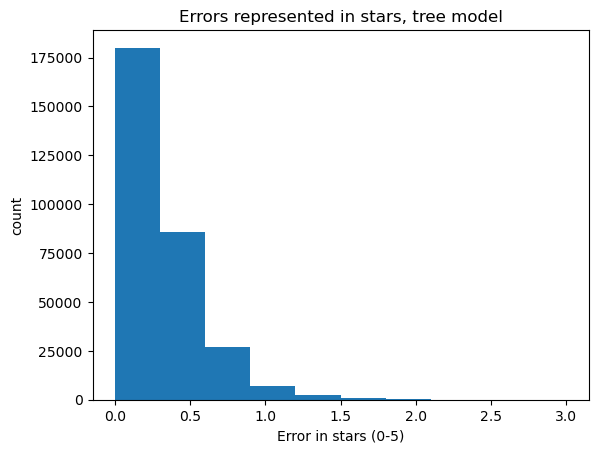

In [44]:
abs_error = np.abs(np.array(y_test) - np.array(y_pred).flatten())
plt.hist(abs_error, bins=10, range=(0,3))
plt.ylabel('count')
plt.xlabel('Error in stars (0-5)')
plt.title('Errors represented in stars, tree model')
plt.show()

After running our grid search, we actually can see our model performed about 2% better, which is pretty good. Additionally, we can see most of our errors are actually pretty close to 0-0.5 stars, which is really good. Our RMSE value decreased, as well as our R2 score, which shows how well the predicted model fits the data. Furthermore, we can see that when we find the most important feature, it is still consistent with 'review_taste', but now has significantly less weight. This logically makes sense that the taste is the most important feature, and even though the weight decreased in this model, we still think the other features should be weighted more heavily than just the taste. Overall, decision trees are a pretty good model choice on this dataset, because it can model nonlinear relationships and also because it is not a parametric model that makes assumptions about our data.

In [45]:
###### See here! I think checking the r-value is more straightforward? Like the r-squared value has been 
###### up by 0.05, which is pretty good. Besides, I think a higher r score means a better model? So the 
###### RMSE decreased but the r increased.

## Subsection 3: Fully connected Neural Network

##### A little behind model selection/Why Neural Networks?:

As noted in the research paper from lecture, we know that the best performing models over all variety of datasets are decision trees and neural networks, which is partially why we choose to implement it here. More specifically, it is because neural networks are able to learn both linear and nonlinear relationships with no problem. From our models beforehand, it seems like there is a possible linear relationship between our features and the predicted rating, but that isn't something that we can fully confirm. Choosing a neural network allows us to learn these nonlinear relationships using hidden layers and nonlinear activation functions. We added a few layers in order to add to the complexity of the model to test if the model actually accurately learned these relationships. We will go deeper into the layer architecture below.

In [67]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from sklearn.utils.class_weight import compute_class_weight

If you look at the data section, we found that our ratings/classes are very imbalanced; we need to give the ratings that appear less frequently to have more weight.

In [68]:
class_weights = dict(enumerate(compute_class_weight('balanced', np.unique(y_train), y_train)))
class_weights

TypeError: compute_class_weight() takes 1 positional argument but 3 were given

In [69]:
###### I got an error from the code above. "compute_class_weight() takes 1 positional argument but 3 were given"

In [70]:
np.unique(y_train)

array([0. , 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ], dtype=float32)

In [71]:
model = Sequential()
model.add(Dense(64, input_shape=(110,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

##### More Model Selection on Neural Network

Our overall neural network design is a recurrent neural network (sequential). We chose this because of its training efficiency as well as its ability to learn from previous mistakes. The back propogation allows the model to adjust the weights during each iteration. Finally, RNN is super flexible when it comes to input and output shapes. We need this, because we have one hot encoded categorical data; meaning our input is pretty large (hence the 110).

Why we chose not to use a regularizer:
- our model is performing poorly on the training data already, meaning it is underfitting. Adding a regularizer just makes the model more generalizable, which we do not need currently.
- if we were to use one, use l1 since we know there are outliers in our dataset.

From class, we learned that having a low number of hidden layers usually makes the model too simple to learn nonlinear relationships. We do not expect our relationships between all the features to be completely linear, so having a couple hidden layers should allow our data to learn complex relationships without overfitting.

Since we are dealing with nonlinear relationships, we should use nonlinear activation functions. Relu is simple and efficient, and allows there to be a gradient everywhere so we can use backpropagation and update weights. In some of our hidden layers, we also use tanh to introduce further nonlinearity.

Note: We tried implementing regularization as well as dropout, but because our model not complex enough/fitting well on the training data, it doesn't make sense to implement these techniques because they help generalize the model better, and we don't need that.


In [72]:
mode = 'none'
save = 'no'

In [73]:
# Compile the model
if mode == 'test':
    optimizer = Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)
    if save== 'yes':
        model.save("beer_nn")
else:
    model = load_model('beer_nn')

OSError: No file or directory found at beer_nn

In [89]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)

9491/9491 [==============================] - 13s 1ms/step


In [90]:
mae = mean_absolute_error(y_test, y_pred)
mae

2404.6516

In [91]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rmse

3433.2341

In [92]:
r2 = r2_score(y_test, y_pred)
r2

-22885915.07113515

In [93]:
abs_error = np.abs(np.array(y_test) - np.array(y_pred).flatten())

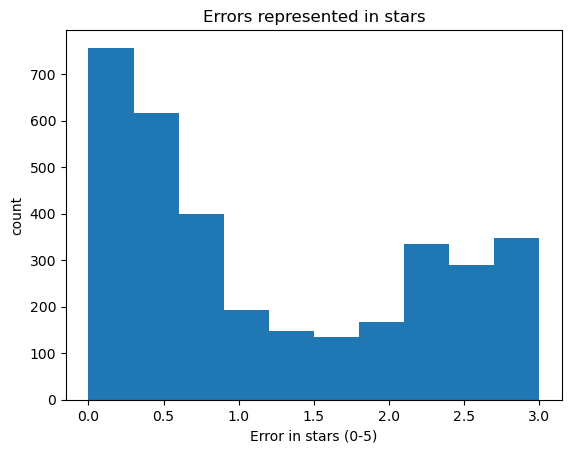

In [94]:
plt.hist(abs_error, bins=10, range=(0,3))
plt.ylabel('count')
plt.xlabel('Error in stars (0-5)')
plt.title('Errors represented in stars')
plt.show()

We can see our neural network model performs actually worse than our tree model. We tried using both a very complex model to see if we could acheive no training error as well as a very simple model, but both didn't end up performing well. As a result, we just stuck with an architecture in the middle. In fact, we suspect that our tree model performs better than our neural network because of non-linearity in our data: our complex model wasn't able to easily learn these relationships, but our decision tree was.

Now, let's see what our model determines the most important feature is at each layer.

In [95]:
def get_most_important_feature(model,layer:int):
    weights = model.layers[layer].get_weights()[0]
    most_important_features = np.argmax(weights, axis=0)
    return X.columns[np.argmax(most_important_features)], np.max(most_important_features)

In [96]:
feature, _ = get_most_important_feature(model=model,layer=0)
print("The most heavily weighted feature is", feature)

The most heavily weighted feature is American Stout


In [97]:
feature, _ = get_most_important_feature(model=model,layer=1)
print("The most heavily weighted feature is", feature)

The most heavily weighted feature is American Amber / Red Ale


In [98]:
feature, weight = get_most_important_feature(model=model,layer=2)
print("The most heavily weighted feature at is", feature,'; the weight is', weight)

The most heavily weighted feature at is American Black Ale ; the weight is 30


We can see at the beginning, a specific beer type is the most important feature due to not fully being trained, but by the end, 'beer_abv' is the most important at 28%. This makes sense, because being the alcohol level logically definitely plays apart on your rating (a person will rate it higher/lower depending on if they want to be drunk or not). Additionally, the weight percentage is also more logical than our baseline, where its most heavy weight was 91%.

### Subsection 4: Building a Recommendation System

##### Some model selection

We want to build a recommendation system, so we need to use our best model, which is actually the improved decision tree (see subsection 2). We will use our model to predict the rating of the beer that the user wants based upon the inputed feature, and then from there give a recommendation on what beer the user should try.

In [85]:
feature_means = X.mean()

In [86]:
abv_input = float(input('What alcohol percentage (0-100) do you want? '))

What alcohol percentage (0-100) do you want? 70


In [87]:
feature_means['beer_abv'] = abv_input
user_input = feature_means.values.reshape(1, -1)
beer_ratings = tree_model.predict(user_input)[0]
print("Predicted beer rating for beers where it has",abv_input,"% abv level is ",beer_ratings)

Predicted beer rating for beers where it has 70.0 % abv level is  3.8051643192488265


In [88]:
df['rating_difference'] = abs(y - beer_ratings)
df = df.sort_values('rating_difference')
top_ten=df[:10]
df_closest = top_ten.iloc[(top_ten['beer_abv']-abv_input).abs().argsort()[:1]]
beer_id = df_closest['beer_beerid'].values[0]
beer_name = beer_dict.get(beer_id)
print("You should try",beer_name)

You should try Blackfriar


# Discussion of Results

- Neural Networks are not always the answer!
    - although NNs perform decently for almost all tasks, there usually is a better model with some critical thinking
    - from our EDA, we can clearly see the bias in our results, since the ratings fell around 4 most of the time
    - there also were issues of multicollinearity as well as outliers
    - deciding on NN with many of these issues makes it difficult to come up with a good architecture to learn these complex relationships between features
    - In the end, we can see that our improved decision tree, which accounted for all of these faults in our data, performed so much better (MAE=0.30) than our neural network (MAE=0.63)

- Architecture of the Tree is more fit for our data
    - take a look at our baseline tree visualization, and imagine it for our improved tree but deeper and more complex (we couldn't plot it or else the kernel would crash)
    - inherently our data fits this representation much better
        - allows us not to just assume if our data is nonlinear or linear, nor does it care about the biases in our results
            - the biases are just divided into their own subbranches before it makes the prediction
    - looking at the graph of errors, we can see most of our errors fall in between 0-0.5 stars only, while the neural network has errors sometimes between 1.5-2 stars
    - Overall the decision tree fits our data well since it can solve all the problems we have in our dataset.

- Neural Network Weights Architecture
    - when designing our architecture, we knew that the predictions of ratings where heavily biased, which is why we had to balance the classes
    - balancing classes essentially puts more weight on ratings that don't appear often and less on ratings that occur most of the time
    - before doing this, our performance was terrible (MAE = 0.8), adding this improved our performance by 0.2
    - Assumed that our output should be a linear layer, but we wanted to possibly learn nonlinear relationships, which is why we used nonlinear activation function
        - however, we don't know if the relationship is truly linear or not
    - architecture is heavily influenced by what you expect in your results as well as the shortcomings in your dataset

- Improvement in Grid Search
    - in our grid search, we implemented a random search because it took us too long to exhaustively search for the optimal parameters
        - using exhaustive search will most definitely improve our performance on the model

### Limitations:

The limitation of this problem is actually the huge size of our dataset not allowing us to completely search through all the parameters in an efficient timely manner. This can easily be solved with better machines, but we simply just do not have these resources at the time. More specifically, we could test the exhaustive grid search, as well as choosing more complex layers for our neural network to possibly perform better.

### Ethics/Privacy:

There is definitely bias/imbalanced data in this dataset. We say this because as humans, we don't really rate things 0 or 5 on a 0-5 scale. Unless something is super bad or super good, we probably would rate it in between something like 3.5 to 4.5. This can severely affect our model predictions, so we need to take this into account.

Further, we need to remove the names of the people that gave the reviews for the beers to preserve anonminity.

Additionally, the ratings of some samples may occur when a person is already drunk, causing them to rate much higher or lower than if they were sober. It may also depend on how much fun they had while drunk. This also is sampling error, which we can't do much about.

# Conclusion TODO:

When rating beers, in order to find out the relationship between the influential features (e.g., smell, taste, alcohol content) and the overall rating score people would give, we first create baseline models to get a vague impression of how our data will be like after training. Then we create a more complicated model - a fully connected neural network to fix previous misclassifications and make our modeling more accurate.

In the outside baseline we found that … In our own baseline model, we choose to implement Decision Tree for it allows us to assume nothing about our data (able to handle bias in the data also handle multicollinearity) as well as trains rapidly.  First we implement a model which has a max depth of 3. From this decision tree model, we can learn that the most important feature is the <b>review of taste</b>, which takes 98.53% among all the features. This indicates that the review of taste is of vital importance but also taking too much weights, so fitted weights should be considered and put onto the features in our future models. The MAE value for this decision tree model (max depth = 3) is 0.32 and the R-squared value is 0.63, which is acceptable but we assume it can perform better by tuning its parameter, so in the next step we implement an improved decision tree model by using a randomized grid search to find the best parameter. By using a randomized grid search, we find the best depth for the tree model is 10, the best minimum samples leaf is 12 and the best minimum samples split is 7. By fitting this tree model to our data, we can find that the most important feature remains to be the <b>review of taste</b>, however, the weight it takes has been reduced to 91.55%. The MAE value for this improved decision tree model is 0.31 and the R-squared value is 0.68, which is 0.05 higher than the original tree model, meaning it’s performing even better.

After training our data using Decision Tree as the baseline model, we choose to implement a more complicated model which is Neural Network in order to obtain a more accurate one for our data. It can both handle linear and non-linear relationships and allows us to learn complex relationships using hidden layers and activation features. We use a Neural Network which ……. 


# Team Expectations

* Be available on the weekends to work together if neccessary, otherwise individually complete assigned work during weekday
* Inform all team members through group chat on updates/something is pushed to github
* Finish all required parts at least 2 days before deadline is due

# Project Timeline Proposal


| Meeting Date  | Meeting Time| Completed Before Meeting  | Discuss at Meeting |
|---|---|---|---|
| 2/16  |  1 PM |  Brainstorm topics/questions (all)  | Determine best form of communication; Discuss and decide on final project topic; discuss hypothesis; begin background research | 
| 2/17  |  10 AM |  Do background research on topic and come up with basic model (George) | Discuss ideal dataset(s) and ethics; draft project proposal | 
| 2/20  | 10 PM  | Edit, finalize, and submit proposal; Search for datasets (All)  | Assign group members to lead each specific part   |
| 3/1  | 6 PM  | Begin Neural Network architecture design/programming(George) | Discuss Analysis Plan   |
| 3/4 | 12 PM  | Write recommendation system(George) | Discuss/edit project code; Complete project |
| 3/12  | 12 PM  | Draft results/conclusion/discussion (Xinyao/Yingnan)| Discuss/edit full project |
| 3/19  | Before 11:59 PM  | NA | Turn in Final Project  |

# Footnotes
<a name="preferences">1</a>: AI of Things, one Telefonica Tech´s business unit. “The Use of AI and Machine Learning in the Beer Industry.” Think Big/Business, 18 June 2021, https://business.blogthinkbig.com/the-use-of-ai-and-machine-learning-in-the-beer-industry/. <br>

<a name="classification">2</a>: da Costa, Nattane Luíza, et al. “A Review on the Application of Chemometrics and Machine Learning Algorithms to Evaluate Beer Authentication - Food Analytical Methods.” SpringerLink, Springer US, 26 Sept. 2020, https://link.springer.com/article/10.1007/s12161-020-01864-7. 


<a name="beer">3</a>: Editor, MathWorks. “Making Better Beer and Wine with Data and Machine Learning.” Medium, MathWorks, 23 Sept. 2020, https://medium.com/mathworks/making-better-beer-and-wine-with-data-and-machine-learning-dd04459f53b7. 